In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import plotly.graph_objects as go

## Chargement du PATH vers les fichier Listes

In [2]:
LIST_PATH_1 = "../data/params/List1.txt"
LIST_PATH_2 = "../data/params/List2.txt"

## Fonction de génération de Time-Series

In [64]:
def generation(h,tension,u,clo,eps,LIST_PATH,TS_INDEX):
    """
    Pipeline entre les paramètres d'entrées et les modèles de prédiction
    
    Paramètres
    ----------
    h_list       : float  :Valeur de h à tester
    tension      : float : Valeur de tension à tester
    u            : float : Valeur de u à tester
    clo          : float : Valeur de cl0 à tester
    LIST_PATH   : string : Chemin vers le fichier liste
    TS_INDEX_serie : int   : Numéro de la time-series à exécuter (commence à 0)
    """

    data_list = pd.read_csv(LIST_PATH , delim_whitespace=True)
    set_params = data_list.iloc[TS_INDEX,:]
    
    list_number = LIST_PATH[-9:]
    
    if(list_number == "List1.txt"):
        ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))
        print("Liste_1")
    if(list_number == "List2.txt"):
        ref = pd.read_csv("../data/ref/list2/graph{}.csv".format(set_params["nc"]))
        print("Liste_2")
    if(list_number !=  "List1.txt" and list_number != "List2.txt" ):
        print("error")




    #print("################ eps value: {} ################".format(eps_value))
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))


    cfg["cable"]["h"] = float(h)

    cfg["simulation"]["tf"] = float(set_params["tf[s]"])

    cfg["cable"]["tension"] = float(tension)

    cfg["wakeosc"]["u"] = float(u)

    cfg["wakeosc"]["cl0"] = float(clo)

    cfg["wakeosc"]["eps"] = float(eps)



    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) # MODIF DT
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) # MODIF DR



    print("h value: ", cfg["cable"]["h"], " u value: ", cfg["wakeosc"]["u"]," tension value: ",cfg["cable"]["tension"],
         "clo value ",cfg["wakeosc"]["cl0"])
    print("tf value ", cfg["simulation"]["tf"])
    dfy, _ = simulation.run_cable_wakeosc(cfg)



    plt.figure(figsize = (20,5))
    plt.plot(ref['time'], ref['y/d'], label = "ref")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "sim")
    plt.xlabel('time (s)')
    plt.ylabel('y/d')

    plt.legend()
    plt.show() 


    print("R2 : ",r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1]))
    print("MSE : ",mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])) # Correct

    return ref,dfy


## Calcul des simulations à concaténer

Liste_2
h value:  100.0  u value:  2.15  tension value:  32100.0 clo value  0.6
tf value  18.6224


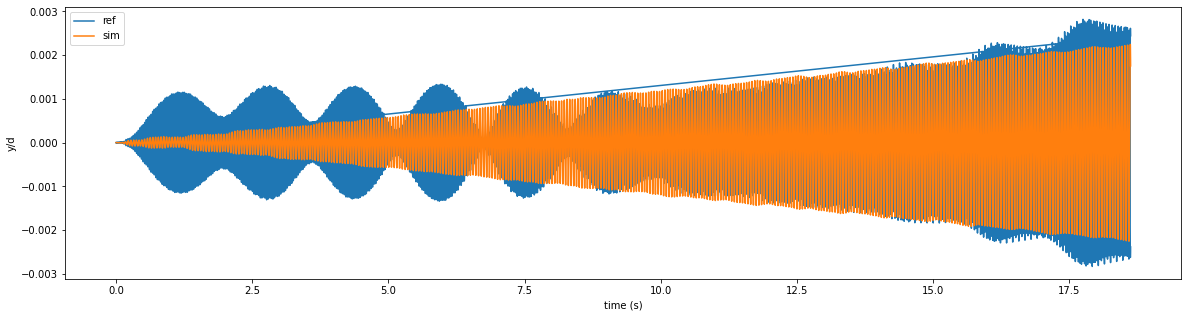

R2 :  -0.8301956526529186
MSE :  1.8150476417742827e-06
Liste_2
h value:  100.0  u value:  2.15  tension value:  32200.0 clo value  3.0
tf value  40.0


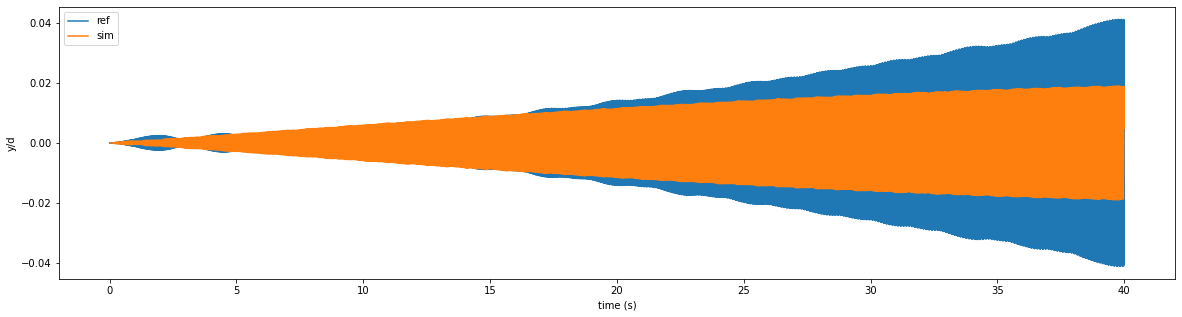

R2 :  -0.5479467916407075
MSE :  0.00021077039711237978
Liste_1
h value:  309.49288554663354  u value:  0.9535838147886668  tension value:  11605.8732786244 clo value  0.6
tf value  4.0


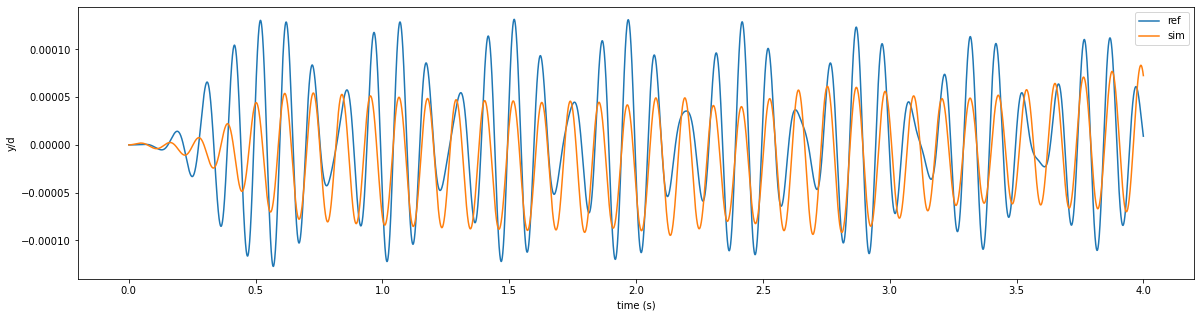

R2 :  0.5432108921915703
MSE :  1.7705167468842946e-09
Liste_1
h value:  385.75324043420676  u value:  0.9198665553364257  tension value:  20922.45861417 clo value  0.01
tf value  7.206


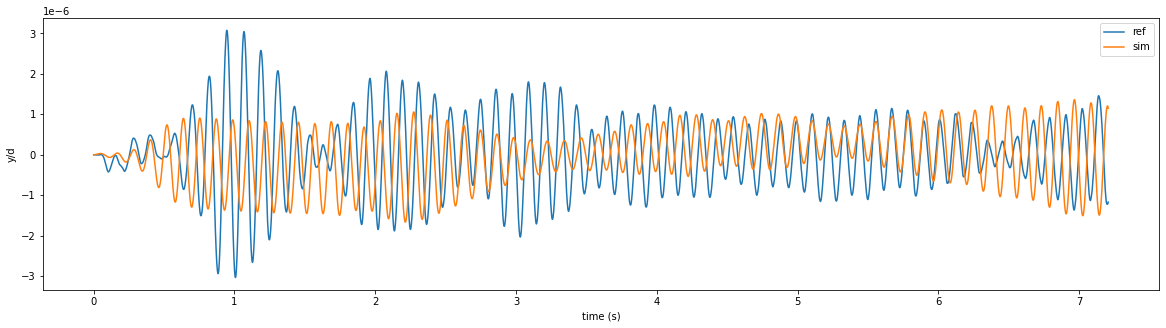

R2 :  -0.8352574219481199
MSE :  1.5222742759555531e-12


In [65]:
ref_TS_1_List_2,sim_TS_1_List_2 = generation(100,32100,2.15,0.6,0.3,LIST_PATH_2,0)
ref_TS_2_List_2,sim_TS_2_List_2 = generation(100,32200,2.15,3.0,0.3,LIST_PATH_2,1)
ref_TS_1_List_1,sim_TS_1_List_1 = generation(309.49288554663354,11605.8732786244,0.9535838147886668,0.6,0.3,
                                             LIST_PATH_1,5)
ref_TS_6_List_1,sim_TS_6_List_1 = generation(385.75324043420676,20922.45861417,0.9198665553364257,0.01,0.3,
                                             LIST_PATH_1,0)

## Chargement de toutes les simulations et réferences pour la modélisation avec concaténation

In [154]:
list_reference = []
list_reference.append(ref_TS_1_List_2)
list_reference.append(ref_TS_2_List_2)
list_reference.append(ref_TS_1_List_1)
list_reference.append(ref_TS_6_List_1)


list_simulation = []
list_simulation.append(sim_TS_1_List_2)
list_simulation.append(sim_TS_2_List_2)
list_simulation.append(sim_TS_1_List_1)
list_simulation.append(sim_TS_6_List_1)

## Traitement des données

In [155]:
def preprocessing(list_dfy,list_ref):
    """
    Récupérations des valeurs positives des modèles de simulations et des modèles de  réferences
    Concaténation des simulations d'un coté et les réferences de l'autre
    Split 80 / 20 des données
    
    Arguments : list_dfy : Liste de toutes les simulations à concaténer
                list_ref : Liste de toutes les references à concaténer
                
    Retour : X_train (80 % sim)
            X_test (20% sim)
            y_train (80% ref)
            y_test (20% ref)
               
    """
    list_sim_pos = []
    list_ref_pos = []
    for i in range(0, len(list_dfy)):
        sim_data = list_dfy[i]['s=0.250'].iloc[1:,]/0.025
        ref_data = list_ref[i].set_index("time").sort_index()['y/d']
        
        sim_ref_data = pd.concat([
        pd.DataFrame(sim_data.values,columns = ["sim"]),
        pd.DataFrame(ref_data.values[ref_data.values >= 0], columns = ["ref_pos"]),
        pd.DataFrame(ref_data.values[ref_data.values < 0], columns = ["ref_neg"])   
        ],axis = 1)


        pd.DataFrame(sim_data.values,columns = ["sim"])

        sim_df = sim_ref_data
        sim_pos = sim_df[sim_df.sim >= 0].sim.values
        ref_pos = sim_df["ref_pos"].dropna().values

        if(len(ref_pos) > (len(sim_pos))):
            ref_pos = ref_pos[:sim_pos.shape[0]]
        if(len(ref_pos) <= (len(sim_pos))):
            sim_pos = sim_pos[:ref_pos.shape[0]]
        list_sim_pos.append(sim_pos)
        list_ref_pos.append(ref_pos)

    sim_pos_final = np.concatenate((list_sim_pos))
    ref_pos_final = np.concatenate((list_ref_pos))


    X_train, X_test, y_train, y_test = train_test_split(sim_pos_final,ref_pos_final,test_size = 0.2, random_state = 143,shuffle = True)


    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)


    return X_train,X_test,y_train,y_test

## Entrainement des données

In [156]:
def train(X_train, X_test, y_train, y_test):
    
    """
    Entraîne un modèle RandomForest et calcule la prédiction
    Arguments : X_train, 
                X_test, 
                y_train,
                y_test
                
    Retour : y_pred (prédiction du modèle Random Forest)
    """
    reg = RandomForestRegressor()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    
    return y_pred


## Evaluation du modèle

In [157]:
def evaluate_model(y_pred,y_test):
    """
    Evaluation de la prédiction du modèle
    
    Arguments: y_pred
                y_test
                
    Sortie : mse : mean_squared_error
            rmse = root mean squared error
            mea = mean absolute error
            r2 = r2_score
    """
 
    mse = mean_squared_error(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred,squared = False)
    mea = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    return mse,rmse,mea,r2

## Visualisation du modèle avec matplotlib

In [158]:

def plt_model(y_pred,y_test):
    """
    Plot la reference et la prédiction côte à côte  avec résultats des indicateurs 
    
    y_pred  :  numpy.ndarray  : Prédiction du modèle sur les données test du simulateur
    y_test  :  numpy.ndarray  : sortie du modèle de reference dont on doit se rapprocher
    
    
    """
    plt.figure(figsize = (20,8))
    plt.plot(y_test, label = "Signal du modèle reférence")
    plt.plot(y_pred, label = "Signal de la prédiction")

    mse,rmse,mea,r2_score = evaluate_model(y_pred,y_test)
    mse_text = "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    r2_text = "R2_SCORE = %s " % r2_score
  

    plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
        

    #plt.figtext(0.5, -0.20, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(h,tension,u,clo,eps), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    
    
    title = " Comparaison entre le modèle de réference et la prédiction du modèle d'apprentissage Random Forest"
    plt.title(title,fontsize = 18)
    plt.xlabel("Timesteps")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()


## Visualiation du modèle avec Plotly

In [159]:
def plotly_model(y_pred,y_test):
    """
    Plot la reference et la prédiction côte à côte  avec résultats des indicateurs 
    
    y_pred  :  numpy.ndarray  : Prédiction du modèle sur les données test du simulateur
    y_test  :  numpy.ndarray  : sortie du modèle de reference dont on doit se rapprocher
    
    
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(y = y_test,
                    name='Signal de reference'))
    fig.add_trace(go.Scatter(y = y_pred,
                    name='Signal de prediction'))
    
    fig.update_layout(
        title=" Comparaison entre le modèle de réference et la prédiction du modèle d'apprentissage Random Forest",
        xaxis_title="Timesteps",
        yaxis_title="Signal",
        legend_title="Signaux",       
    )


    fig.show()
    fig.write_html("../outputs/visualisation/modelisation_concatenee/Concat_4_TS.html")

## Pipeline de modélisation concaténée

In [160]:
def pipeline_concat(list_simulation,list_reference):

    """
    Pipeline de Modélisation Concaténéee
    
    Arguments: 
            list_simulation (liste des simulations à concaténer)
            list_reference (liste des réferences à concaténer)
            
    Sortie :
            Plot de la prédiction du modèle Random Forest avec matplotlib
            Plot de la prédiction du modèle Random Forest avec Plotly

    """
    
    X_train, X_test, y_train, y_test = preprocessing(list_simulation,list_reference)
    y_pred = train(X_train, X_test, y_train, y_test)
    
    plt_model(y_pred,y_test)
    plotly_model(y_pred,y_test)


## Lancement de la Pipeline

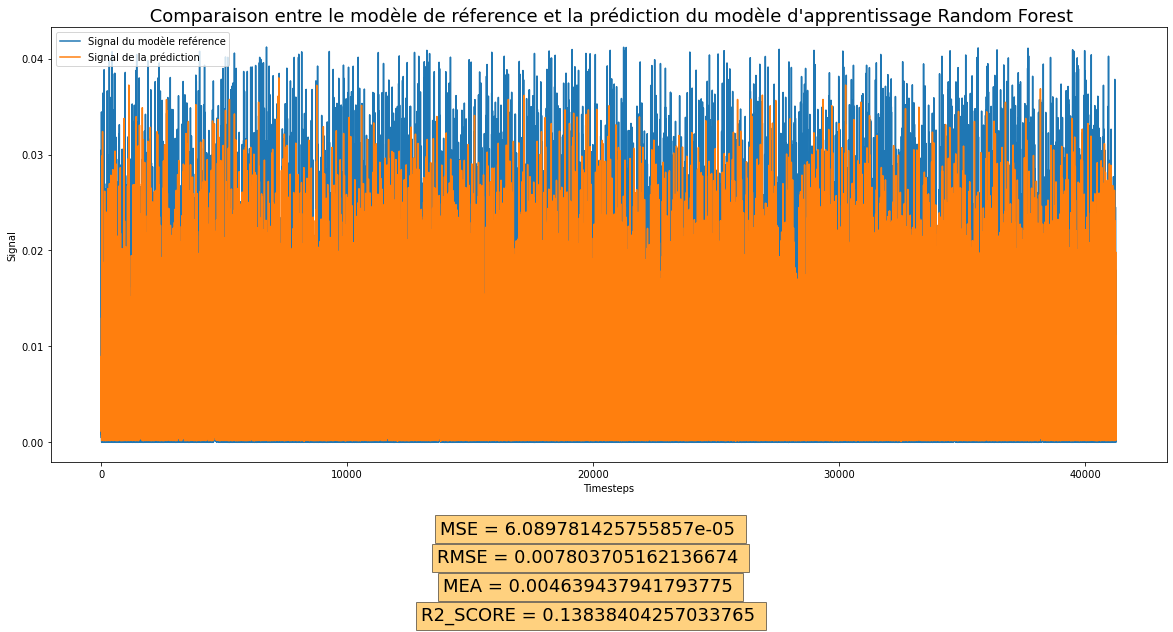

In [161]:
pipeline_concat(list_simulation,list_reference)